In [ ]:
!pip install cartopy
import cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 87.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib. pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

df = pd.read_csv('uscities.csv')
#removing those cities that are very close in the map for readability
city_to_remove = 'Philadelphia'
df = df[df['city'] != city_to_remove]
city_to_remove = 'Brooklyn'
df = df[df['city'] != city_to_remove]
city_to_remove = 'Queens'
df = df[df['city'] != city_to_remove]
city_to_remove = 'Baltimore'
df = df[df['city'] != city_to_remove]
city_to_remove = 'Riverside'
df = df[df['city'] != city_to_remove]
df_large = df[df['population'] >= 2000000]
df_large = df_large.reset_index(drop=True)
new_cities = df_large[['city','lat','lng']]
extracted_city = df.iloc[31]
extracted_city_data = extracted_city[['city', 'lat', 'lng']]
# We need to convert it to a DataFrame and transpose it because concat expects a DataFrame, not a Series
extracted_city_df = pd.DataFrame([extracted_city_data]).reset_index(drop=True)
new_cities = pd.concat([new_cities, extracted_city_df], ignore_index=True)
print("number of cities:",len(new_cities))
print(new_cities)

number of cities: 22
             city      lat       lng
0        New York  40.6943  -73.9249
1     Los Angeles  34.1141 -118.4068
2         Chicago  41.8375  -87.6866
3           Miami  25.7840  -80.2101
4         Houston  29.7860  -95.3885
5          Dallas  32.7935  -96.7667
6         Atlanta  33.7628  -84.4220
7      Washington  38.9047  -77.0163
8          Boston  42.3188  -71.0852
9         Phoenix  33.5722 -112.0892
10        Detroit  42.3834  -83.1024
11        Seattle  47.6211 -122.3244
12  San Francisco  37.7558 -122.4449
13      San Diego  32.8313 -117.1222
14    Minneapolis  44.9635  -93.2678
15          Tampa  27.9945  -82.4447
16         Denver  39.7620 -104.8758
17      Las Vegas  36.2333 -115.2654
18      St. Louis  38.6359  -90.2451
19       Portland  45.5371 -122.6500
20    San Antonio  29.4632  -98.5238
21      Cleveland  41.4764  -81.6805


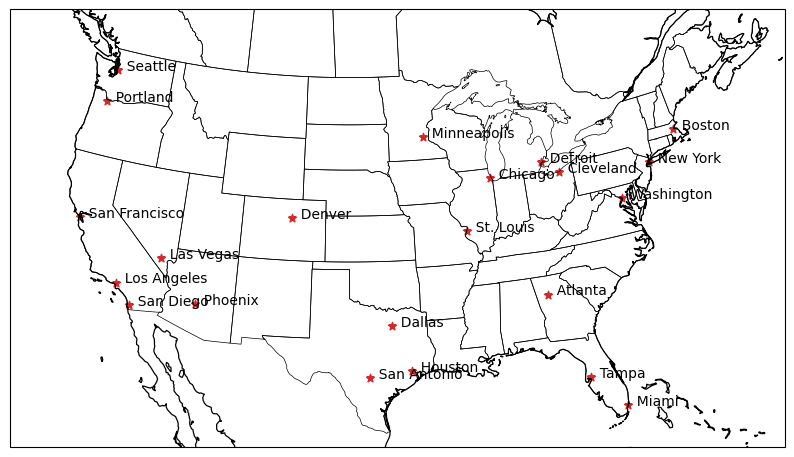

In [ ]:
crs = ccrs. LambertConformal (central_longitude=-100, central_latitude=45)
fig = plt. figure(figsize=(10, 10))
ax = fig. add_subplot (1, 1, 1, projection=crs)
ax. set_extent ((-124, -69, 25, 50), crs= ccrs.PlateCarree())
ax. add_feature(cfeature. COASTLINE.with_scale('50m'), linewidth=0.9)
ax. add_feature (cfeature. STATES, linewidth=0.5)
for _, city in new_cities.iterrows():
    ax.scatter(city['lng'], city['lat'], transform = ccrs.PlateCarree(), color= 'tab:red', marker='*')
    ax.text(city['lng'], city['lat'],'  '+city['city'], transform=ccrs.PlateCarree(),clip_on=True)

In [ ]:
import numpy as np
import random
import math as m

class AntColonyOptimizer:
    def __init__(self, distances, city_names, n_ants, n_iter, decay, alpha=0.7, beta=0.9, Q=10):
        self.distances = distances
        self.city_names = city_names
        self.pheromone = np.ones(distances.shape) * 0.01  # Initial pheromone levels
        self.n_ants = n_ants
        self.n_iter = n_iter
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.Q = Q  # Constant for pheromone update

    def run(self, start_idx, end_idx):
        path_count = {}
        for iteration in range(self.n_iter):
            all_paths = []
            #print("iteration",iteration+1)
            for ant in range(self.n_ants):
                path, cost = self.gen_path(start_idx, end_idx)

                path_cities = [self.city_names[idx] for idx in path]
                #print(f"  Ant {ant + 1},{path_cities}, Cost: {cost}")
                path_key = tuple(path)
                path_count[path_key] = path_count.get(path_key, 0) + 1

                all_paths.append((path, cost))

            self.update_pheromone(all_paths)

        return self.find_best_path(all_paths,path_count)


    def find_best_path(self, all_paths, path_count):
      # Find the path with the minimum cost
      best_path_tuple = min(all_paths, key=lambda x: x[1])
      best_path = best_path_tuple[0]
      best_cost = best_path_tuple[1]

      # Convert path indices to city names
      best_path_cities = [self.city_names[idx] for idx in best_path]

      # Count how many ants took this path
      best_path_count = path_count.get(tuple(best_path), 0)
      #print(f"Number of ants that took the best path: {best_path_count}")

      return best_path_cities, best_cost


    def gen_path(self, start_idx, end_idx):
        path = [start_idx]
        visited = set([start_idx])

        # First, select an intermediate city that is not the destination
        intermediate_idx = self.pick_next_city(start_idx, end_idx, visited, intermediate=True)
        path.append(intermediate_idx)
        visited.add(intermediate_idx)

        # Then, continue to the destination with usual path generation
        while path[-1] != end_idx:
            current_idx = path[-1]
            next_idx = self.pick_next_city(current_idx, end_idx, visited)
            path.append(next_idx)
            visited.add(next_idx)
        return path, self.path_cost(path)

    def pick_next_city(self, current_idx, end_idx, visited, intermediate=False):
        pheromone = np.array([self.pheromone[current_idx][i] for i in range(len(self.city_names))])
        distances = self.distances[current_idx]
        desirability = 1 / (distances + 1e-10)

        # Zero out pheromone and desirability for visited cities and the current city
        mask = np.ones(len(self.city_names), dtype=bool)
        mask[list(visited)] = False
        if intermediate:
            mask[end_idx] = False   # Exclude the destination for the first selection
        pheromone *= mask
        desirability *= mask

        attractiveness = (pheromone ** self.alpha) * (desirability ** self.beta)
        total_attractiveness = np.sum(attractiveness)

        if total_attractiveness == 0:
            # Handle case where no unvisited cities are left
            return end_idx if not intermediate else np.random.choice(np.where(mask)[0])

        probabilities = attractiveness / total_attractiveness
        next_city = np.random.choice(range(len(self.city_names)), p=probabilities)
        return next_city


    def update_pheromone(self, all_paths):
          self.pheromone *= (1 - self.decay)  # Pheromone evaporation
          for path, cost in all_paths:
              deposit = self.Q / cost
              for i in range(len(path) - 1):
                  self.pheromone[path[i]][path[i + 1]] += deposit

    def path_cost(self, path):
          return sum(self.distances[path[i]][path[i + 1]] for i in range(len(path) - 1))

def cartesian_matrix(coordinates):
    # Create a matrix based on Cartesian coordinates
    matrix = np.zeros((len(coordinates), len(coordinates)))
    for i, coord1 in enumerate(coordinates):
        for j, coord2 in enumerate(coordinates):
            if i == j:
                matrix[i][j] = float('inf')
            else:
                matrix[i][j] = m.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)
    return matrix

def convert(lat, lng):
    # Convert latitude and longitude to Cartesian coordinates
    latitude = m.radians(lat)
    longitude = m.radians(lng)
    x = 6371 * m.cos(latitude) * m.cos(longitude)   #earth radius=6371
    y = 6371 * m.cos(latitude) * m.sin(longitude)
    return x, y

# Main execution
if __name__ == "__main__":
    coordinates = [convert(row['lat'], row['lng']) for index, row in new_cities.iterrows()]
    city_names = new_cities['city'].tolist()
    for x, i in enumerate(city_names):
      if x % 12 == 0:
          print( )
      print(i, end=' , ')

    # Create distance and pheromone matrices
    distances = cartesian_matrix(coordinates)
    # Get user input for source and destination
    source_city = input("\nEnter source city: ")
    destination_city = input("Enter destination city: ")
    n_ants = int(input("Enter the number of ants: "))
    n_iter = int(input("Enter iterations:"))

    source_idx = city_names.index(source_city)
    destination_idx = city_names.index(destination_city)

    aco = AntColonyOptimizer(distances, city_names, n_ants=n_ants, n_iter=n_iter, decay=0.001, alpha=0.9, beta=0.9, Q=10)
    best_paths, best_cost = aco.run(source_idx, destination_idx)
    print("Best path:", best_paths)
    print("Best cost:", best_cost)



New York , Los Angeles , Chicago , Miami , Houston , Dallas , Atlanta , Washington , Boston , Phoenix , Detroit , Seattle , 
San Francisco , San Diego , Minneapolis , Tampa , Denver , Las Vegas , St. Louis , Portland , San Antonio , Cleveland , 
Enter source city: Boston
Enter destination city: Los Angeles
Enter the number of ants: 100
Enter iterations:200
Number of ants that took the best path: 3
Best path: ['Boston', 'New York', 'Detroit', 'Chicago', 'Los Angeles']
Best cost: 4121.08134774421


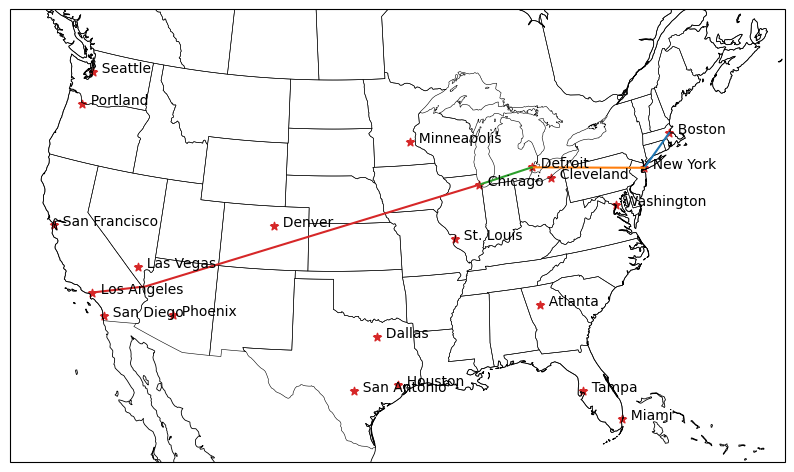

In [ ]:
#get the best path cities latitude and longitude
selected_cities = new_cities[new_cities['city'].isin(best_paths)].set_index('city').loc[best_paths].reset_index()
citieslatlng = selected_cities[['city','lat','lng']]

crs = ccrs. LambertConformal (central_longitude=-100, central_latitude=45)
fig = plt. figure(figsize=(10, 10))
ax = fig. add_subplot (1, 1, 1, projection=crs)
ax. set_extent ((-122, -69, 25, 50), crs= ccrs.PlateCarree())
ax. add_feature(cfeature. COASTLINE.with_scale('50m'), linewidth=0.6)
ax. add_feature (cfeature. STATES, linewidth=0.4)
for _, city in new_cities.iterrows():
    ax.scatter(city['lng'], city['lat'], transform = ccrs.PlateCarree(), color= 'tab:red', marker='*')
    ax.text(city['lng'], city['lat'], '  '+city['city'], transform=ccrs.PlateCarree(),clip_on=True)

#creating lines bewteen the cities
for (i, row), (j, next_row) in zip(citieslatlng.iterrows(), citieslatlng.iloc[1:].iterrows()):
    lon1, lat1 = row['lng'], row['lat']
    lon2, lat2 = next_row['lng'], next_row['lat']
    ax.plot([lon1, lon2], [lat1, lat2], transform=ccrs.PlateCarree())